# User Engagement and Emotional Communication Analysis

This NOTEBOOK accomplishes the following tasks:
1. user stratification analysis based on number of likes
2. Sentiment quality of highly popular tweets vs. regular tweets
3. Sentiment spreading analysis of core users vs. peripheral users

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

sns.set_theme(style="whitegrid")  

In [2]:
# read  data
sentiment_df = pd.read_csv("../2_data/tweet_level_sentiment.csv", parse_dates=["Date"])

meta_df = pd.read_csv("../2_data/cleaned_nvda.csv", parse_dates=["Date"])
meta_df = meta_df[['Date', 'Processed_Tweet', 'likes', 'user']]  

# merge
merged_df = pd.merge(sentiment_df, meta_df, on=['Date', 'Processed_Tweet'], how='inner')

# deal with likes
def extract_likes(likes_info):
    if pd.isna(likes_info):
        return 0
    try:
        if isinstance(likes_info, str):
            import ast
            likes_info = ast.literal_eval(likes_info)
        return likes_info.get('total', 0)
    except Exception:
        return 0

# deal with user
def extract_username(user_info):
    if pd.isna(user_info):
        return 'unknown'
    try:
        if isinstance(user_info, str):
            import ast
            user_info = ast.literal_eval(user_info)
        return user_info.get('username', 'unknown')
    except Exception:
        return 'unknown'

# extract likes and username
merged_df['likes'] = merged_df['likes'].apply(extract_likes)
merged_df['username'] = merged_df['user'].apply(extract_username)

print(f"Total tweets: {len(merged_df)}")
print(f"Total users: {merged_df['username'].nunique()}")
print(f"Total likes: {merged_df['likes'].sum()}")

# 保存处理后数据
merged_df.to_csv("../2_data/tweet_level_sentiment_with_userinfo.csv", index=False)

Total tweets: 774038
Total users: 29417
Total likes: 1019471



## 2. Stratification of users based on number of likes

User stratification statistics (active users only):
                       username  total_likes  avg_sentiment  tweet_count
user_type                                                               
High-engagement users      6760          0.0           0.02       106.45


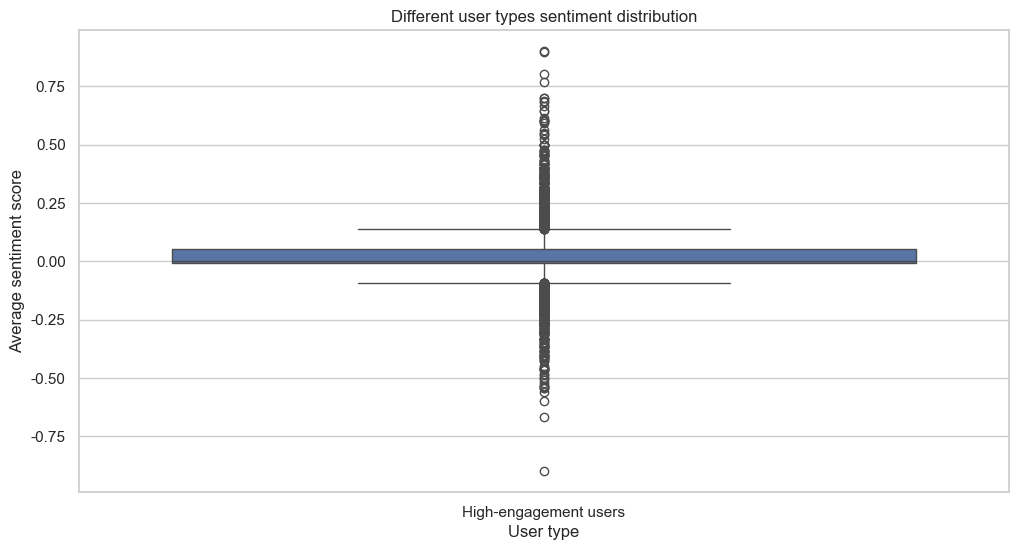

In [ ]:
import ast

def extract_likes(likes_info):
    if pd.isna(likes_info):
        return 0
    try:
        if isinstance(likes_info, str):
            likes_info = ast.literal_eval(likes_info)
        return likes_info.get('total', 0)
    except Exception:
        return 0

merged_df['likes_num'] = merged_df['likes'].apply(extract_likes)

# Start by grouping by username and calculating the total number of likes, average sentiment and tweets
user_engagement = merged_df.groupby('username').agg({
    'likes_num': 'sum',
    'sentiment_score': ['mean', 'std', 'count']
}).reset_index()

user_engagement.columns = ['username', 'total_likes', 'avg_sentiment', 'sentiment_std', 'tweet_count']

# Filter out users with a low number of tweets (e.g. less than 10) and focus only on active users
active_users = user_engagement[user_engagement['tweet_count'] >= 10].copy()

# Calculate high interaction user threshold based on total likes (98% quartile is used here and can be adjusted as needed)
like_threshold = active_users['total_likes'].quantile(0.98)
active_users['user_type'] = np.where(active_users['total_likes'] >= like_threshold, 
                                     'High-engagement users', 'Regular users')

# print
print("User stratification statistics (active users only):")
print(active_users.groupby('user_type').agg({
    'username': 'count',
    'total_likes': 'mean',
    'avg_sentiment': 'mean',
    'tweet_count': 'mean'
}).round(2))

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='user_type', y='avg_sentiment', data=active_users)
plt.title('Different user types sentiment distribution')
plt.xlabel('User type')
plt.ylabel('Average sentiment score')
plt.show()

## 3. Sentiment quality of highly popular tweets vs. regular tweets

In [45]:
print(merged_df['likes_num'].describe())
print(merged_df['likes_num'].value_counts().head(10))

count    774038.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: likes_num, dtype: float64
likes_num
0    774038
Name: count, dtype: int64


In [ ]:
def extract_likes(likes_info):
    if pd.isna(likes_info):  # if likes_info is NaN, return 0
        return 0
    try:
        if isinstance(likes_info, str):  # if likes_info is a string, convert it to a dictionary
            import ast
            likes_info = ast.literal_eval(likes_info)
        return likes_info.get('total', 0)  # Extract the value of the 'total' field
    except Exception as e:
        print(f"Error parsing likes_info: {likes_info}, error: {e}")
        return 0  # Returns 0 if parsing fails
    
merged_df['likes_num'] = meta_df['likes'].apply(extract_likes)

In [50]:
non_zero_likes = merged_df[merged_df['likes_num'] > 0]
print(non_zero_likes['likes_num'].describe())
print(len(non_zero_likes))

count    282114.00000
mean          2.56799
std           2.76649
min           1.00000
25%           1.00000
50%           2.00000
75%           3.00000
max         201.00000
Name: likes_num, dtype: float64
282114


In [51]:
non_zero_likes = merged_df[merged_df['likes_num'] > 0]
print(non_zero_likes['likes_num'].describe())
print(len(non_zero_likes))

count    282114.00000
mean          2.56799
std           2.76649
min           1.00000
25%           1.00000
50%           2.00000
75%           3.00000
max         201.00000
Name: likes_num, dtype: float64
282114


In [52]:
print(meta_df.columns)

Index(['Date', 'Processed_Tweet', 'likes', 'user', 'likes_num', 'tweet_type'], dtype='object')


98% 分位数阈值: 8.0
tweet_type
Regular tweets            761657
High-engagement tweets     12381
Name: count, dtype: int64
Tweet sentiment statistics:
                       sentiment_score                           likes_num
                                 count    mean     std  min  max      mean
tweet_type                                                                
High-engagement tweets           12380  0.0101  0.2438 -1.0  1.0   11.8292
Regular tweets                  761640  0.0115  0.2617 -1.0  1.0    1.1807


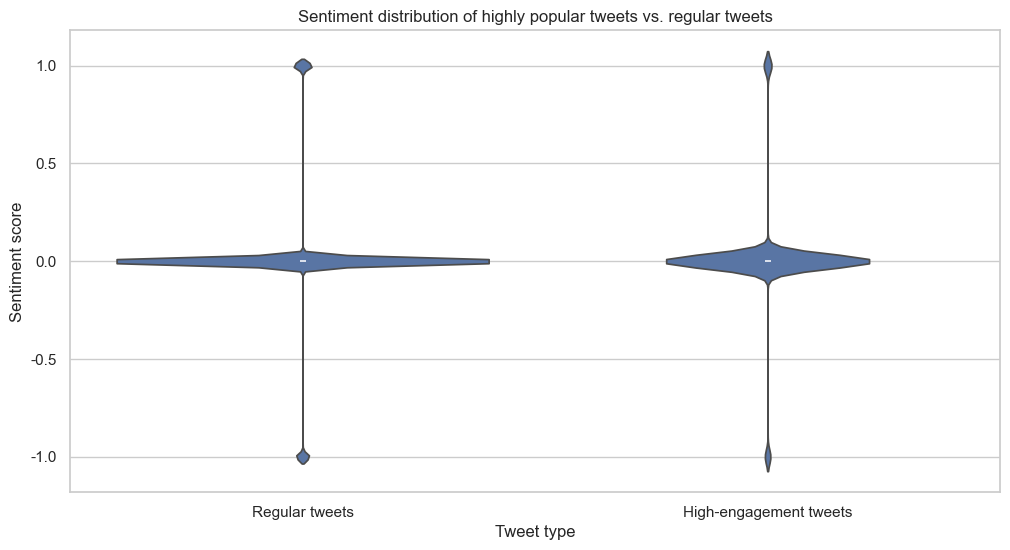

In [53]:
# Define the standard for highly popular tweets

tweet_like_threshold = merged_df['likes_num'].quantile(0.98)
print(f"98% 分位数阈值: {tweet_like_threshold}")
merged_df['tweet_type'] = np.where(merged_df['likes_num'] >= tweet_like_threshold, 'High-engagement tweets', 'Regular tweets')

print(merged_df['tweet_type'].value_counts())


# calculate the sentiment statistics
tweet_sentiment_stats = merged_df.groupby('tweet_type').agg({
    'sentiment_score': ['count', 'mean', 'std', 'min', 'max'],
    'likes_num': 'mean'
}).round(4)

print("Tweet sentiment statistics:")
print(tweet_sentiment_stats)

# visualize the sentiment distribution
plt.figure(figsize=(12, 6))
sns.violinplot(x='tweet_type', y='sentiment_score', data=merged_df)
plt.title('Sentiment distribution of highly popular tweets vs. regular tweets')
plt.xlabel('Tweet type')
plt.ylabel('Sentiment score')
plt.show()


## 4. Emotional communication network analysis

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. change date
merged_df['date_bin'] = pd.to_datetime(merged_df['Date']).dt.date

# 2. create graph
G = nx.Graph()

# add nodes
user_sentiment = merged_df.groupby('user')['sentiment_score'].mean()
for user, sentiment in user_sentiment.items():
    G.add_node(user, sentiment=sentiment)

# group by date, and add edges
for date, group in merged_df.groupby('date_bin'):
    users = group['user'].unique()
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            G.add_edge(users[i], users[j])

# network metrics
print("Network statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# PageRank find core users
pagerank = nx.pagerank(G)
core_users = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nCore users (PageRank ranking top 10):")
for user, score in core_users:
    print(f"{user}: {score:.4f}")



Network statistics:
Number of nodes: 35832
Number of edges: 20208824

Core users (PageRank ranking top 10):
{'id': 951286, 'username': 'tannerb', 'name': 'Tanner Brown', 'avatar_url': 'https://avatars.stocktwits.com/production/951286/thumb-1486688101.png', 'avatar_url_ssl': 'https://avatars.stocktwits.com/production/951286/thumb-1486688101.png', 'join_date': '2017-02-09', 'official': False, 'identity': 'User', 'classification': [], 'followers': 84, 'following': 54, 'ideas': 7580, 'watchlist_stocks_count': 30, 'like_count': 1855, 'plus_tier': '', 'premium_room': '', 'trade_app': False, 'trade_status': None}: 0.0007
{'id': 284016, 'username': 'jayjogia', 'name': 'Jay', 'avatar_url': 'https://avatars.stocktwits.com/production/284016/thumb-1419730966.png', 'avatar_url_ssl': 'https://avatars.stocktwits.com/production/284016/thumb-1419730966.png', 'join_date': '2013-11-23', 'official': False, 'identity': 'User', 'classification': [], 'followers': 175, 'following': 74, 'ideas': 21035, 'watchl

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# assume core_users is the top 10 users id list
core_user_ids = [u for u, _ in core_users]

# 1. only keep tweets from core users
core_df = merged_df[merged_df['user'].isin(core_user_ids)].copy()

# 2. calculate the average sentiment of core users by day
core_daily_sentiment = core_df.groupby('Date')['sentiment_score'].mean().reset_index()
core_daily_sentiment.columns = ['Date', 'core_sentiment']


# 3. read actual price data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv', parse_dates=['index'])
price_df = price_df.rename(columns={'index': 'Date', 'nvda_close': 'Close'})
price_df = price_df.set_index('Date')


# 4. merge
df = pd.merge(price_df, core_daily_sentiment, on='Date', how='left')
df = df.sort_values('Date').reset_index(drop=True)
df['core_sentiment'] = df['core_sentiment'].ffill().bfill()  # missing value fill

print(df.head())

        Date  avg_sentiment_score  tweet_count  sentiment_std  \
0 2019-01-02            -0.028037          214       0.463867   
1 2019-01-03            -0.021352          281       0.470076   
2 2019-01-04             0.000000          210       0.403335   
3 2019-01-07             0.055147          272       0.421615   
4 2019-01-08            -0.029333          375       0.409373   

        model_type  nvda_open  nvda_high  nvda_low    Close  nvda_return  \
0  FinBERT+RoBERTa    3.26600    3.46200   3.25125  3.40550     0.020374   
1  FinBERT+RoBERTa    3.34475    3.37900   3.19225  3.19975    -0.060417   
2  FinBERT+RoBERTa    3.27350    3.44325   3.24250  3.40475     0.064068   
3  FinBERT+RoBERTa    3.46250    3.62225   3.41075  3.58500     0.052941   
4  FinBERT+RoBERTa    3.66725    3.66950   3.42250  3.49575    -0.024895   

   vix_close  core_sentiment  
0  23.219999        0.333333  
1  25.450001        0.000000  
2  21.379999        0.000000  
3  21.400000        0.200000

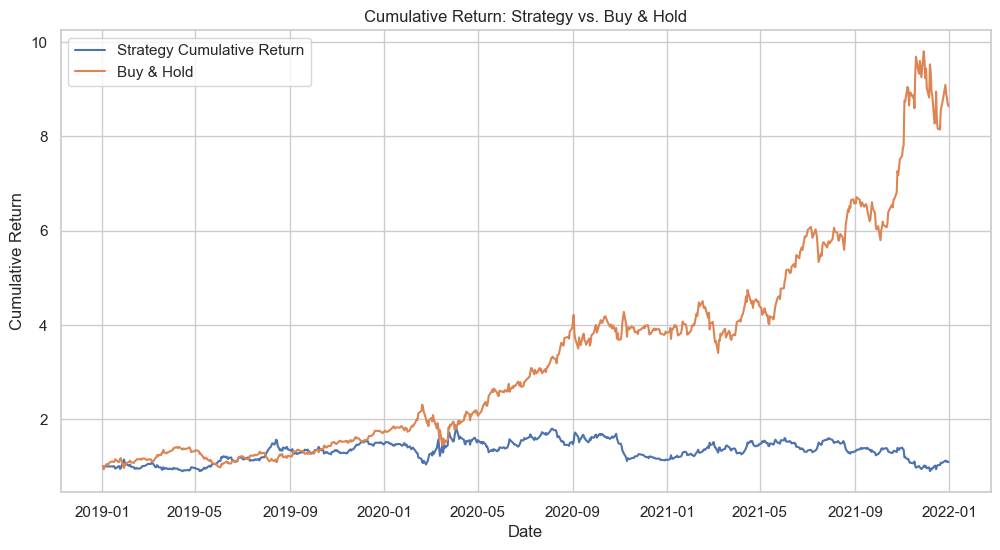

Annual Return: 14.44%
Annual Volatility: 48.15%
Sharpe Ratio: 0.30
Max Drawdown: -50.56%


In [ ]:
# dynamic threshold
df['rolling_mean'] = df['core_sentiment'].rolling(window=10).mean()
df['signal'] = 0
df.loc[df['core_sentiment'] > df['rolling_mean'], 'signal'] = 1
df.loc[df['core_sentiment'] < df['rolling_mean'], 'signal'] = -1

# Generate position status
df['position'] = df['signal'].shift(1).ffill().fillna(0) 

# calculate daily return
df['return'] = df['Close'].pct_change().fillna(0)
df['strategy_return'] = df['position'] * df['return']

# calculate cumulative return
df['cumulative_return'] = (1 + df['strategy_return']).cumprod()
df['buyhold_return'] = (1 + df['return']).cumprod()

# visualize the cumulative return
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['cumulative_return'], label='Strategy Cumulative Return')
plt.plot(df['Date'], df['buyhold_return'], label='Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return: Strategy vs. Buy & Hold')
plt.legend()
plt.show()

# calculate performance metrics
annual_return = df['strategy_return'].mean() * 252
annual_volatility = df['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_volatility
df['cumulative_max'] = df['cumulative_return'].cummax()
df['drawdown'] = df['cumulative_return'] / df['cumulative_max'] - 1
max_drawdown = df['drawdown'].min()

print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")